<a href="https://colab.research.google.com/github/aimerou/notebooks/blob/main/computer_vision/face_recognition_personal_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Install dependencies and import librairies

In [ ]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

In [ ]:
# Install the face recognition model
!pip install keras-vggface
!pip install keras_applications

In [3]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

import PIL
from PIL import ImageOps, Image
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine

In [ ]:
!mkdir known
!mkdir test

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/c/c7/Aimerou_2.jpg -O known/aimerou.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/6/69/Daouda_2.jpg -O known/daouda.jpg
#!wget  -O known/mouhamed.jpg

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/3/3a/Aimerou_1.jpg -O test/1.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/d/d8/Daouda_1.jpg -O test/2.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/6/60/Daouda_and_me_1.jpg -O test/3.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/a/a4/Alioune.png -O test/4.jpg
#!wget  -O test/5.jpg

#### Face detection and recognition functions

In [7]:
# Extract a face from an image with a single face

def extract_one_face(image, network, required_size=(224, 224)):

  # resize it to have a maximum width of 400 pixels
  image = imutils.resize(image, width=400)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  # Pass the blob through the neural network and obtain the detections and predictions.
  network.setInput(blob)
  detections = network.forward()

  best_confidence = detections[:, :, :, 2][0][0][0]
  if best_confidence > 0.5:
    # compute the coordinates of the bounding box
    box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    # crop the face
    face = image[startY:endY, startX:endX]
    # resize pixels to the model size
    face_img = Image.fromarray(face)
    face_img = face_img.resize(required_size)
    face_array = np.array(face_img)
  else:
    face_array = []

  return face_array

In [8]:
# Extract and return from an image the faces and their locations

def extract_faces(image, network, required_size=(224, 224)):

  # resize it to have a maximum width of 400 pixels
  image = imutils.resize(image, width=400)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  # Pass the blob through the neural network and obtain the detections and predictions.
  network.setInput(blob)
  detections = network.forward()

  faces = []
  boxes = []

  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the `confidence` is greater than the minimum confidence threshold
    if confidence > 0.5:
      # compute the (x, y)-coordinates of the bounding box for the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      # crop the face
      face = image[startY:endY, startX:endX]
      # resize pixels to the model size
      face_img = Image.fromarray(face)
      face_img = face_img.resize(required_size)
      face_array = np.array(face_img)
      # update faces and boxes
      faces.append(face_array)
      boxes.append(box)

  return faces, boxes

In [9]:
#VGGFACE model definition for Face recognition

def get_model_scores(faces):
    samples = np.asarray(faces, 'float32')

    # prepare the data for the model
    samples = preprocess_input(samples, version=2)

    # create a vggface model object
    model = VGGFace(model='resnet50',
      include_top=False,
      input_shape=(224, 224, 3),
      pooling='avg')

    # perform prediction
    return model.predict(samples)

#### Load the known faces and their names

In [10]:
img1 = cv2.imread('known/aimerou.jpg')
img2 = cv2.imread('known/daouda.jpg')
images = [img1, img2]

prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

In [11]:
known_faces = []
for image in images:
  known_faces.append(extract_one_face(image, net))

known_names = [
  'Aimerou',
  'Daouda'
]

#### Test the face recognition pipeline on an image

In [18]:
test_image = cv2.imread('test/3.jpg')
test_faces, boxes = extract_faces(test_image, net)

In [ ]:
names = []

for test_face in test_faces:
  model_face_score = []
  for i in range(len(known_faces)):
    faces = [known_faces[i], test_face]
    scores = get_model_scores(faces)
    model_face_score.append(scores)

  cosine_score = []
  for i in range(len(model_face_score)):
    x = model_face_score[i]
    cosine_score.append(cosine(x[0], x[1]))
  min_score = min(cosine_score)
  if min_score <= 0.4:
    index = cosine_score.index(min_score)
    names.append(known_names[index])
  else:
    names.append("Unknown")

In [20]:
for i in range(len(test_faces)):
  box = boxes[i]
  name = names[i]
  (startX, startY, endX, endY) = box.astype("int")
  # resize it to have a maximum width of 400 pixels
  test_image = imutils.resize(test_image, width=400)
  # draw the bounding box of the face with the associated name
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.rectangle(test_image, (startX, startY), (endX, endY), (0, 0, 255), 2)
  cv2.putText(test_image, name, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

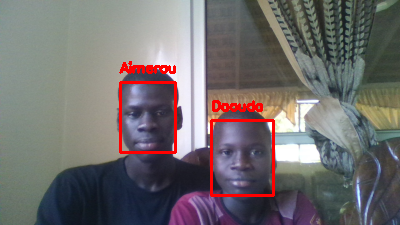

In [21]:
cv2_imshow(test_image)